In [1]:
import numpy as np
import vtk
import matplotlib.pyplot as plt
import os
import netCDF4 as nc
from vtk import vtkUnstructuredGridReader
from vtk import vtkXMLUnstructuredGridReader
from vtk.util import numpy_support as VN
from vtk.util.numpy_support import vtk_to_numpy
from scipy.spatial import KDTree
import pygmt
import pandas
os.chdir("../postprocessing_scripts/")
import MORVEL
os.chdir("../supplemental_figures/")

In [2]:
def cartesian_to_spherical(x, y, z):
    """
    Takes an x, y, z and converts it to spherical coordinates. Returns r, theta, phi
    """
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = 90 - np.rad2deg( np.arccos( z / (np.sqrt(x**2 + y**2 + z**2)) ) )
    phi =  np.sign(y) * np.rad2deg(np.arccos( x / np.sqrt(x**2 + y**2) ))
    phi[np.where(phi < 0)] = phi[np.where(phi < 0)] + 360
    phi[np.where(phi == 0)] = 180
    
    return r, phi, theta

def spherical_to_global_cartesian(r, phi, theta):
    """
    Takes spherical coordinates r, theta, and phi and converts to Cartesian coordinates.
    Returns x, y, z
    """
    x = r * np.sin(np.deg2rad(90 - theta)) * np.cos(np.deg2rad(phi))
    y = r * np.sin(np.deg2rad(90 - theta)) * np.sin(np.deg2rad(phi))
    z = r * np.cos(np.deg2rad(90 - theta))
    
    return x, y, z

In [3]:
base_directory = "../ASPECT_models/5e20_10kmweak_dry/"

trench = np.loadtxt(fname="../data/trench_contour.csv", delimiter=',')[0:270]

solution_dir_path = base_directory + "solution/"
solutions = np.sort(os.listdir( solution_dir_path ))
t_step = 0

if 'pos_solution' in locals():
    del pos_solution, velocity_total, crust_total, litho_total

for soln in solutions:
    if soln[-4:-1] == '.vt' and soln[9:14] == str(t_step).zfill(5):
        file_path = os.path.join(solution_dir_path, soln)
        reader = vtkXMLUnstructuredGridReader()
        reader.SetFileName(file_path)
        reader.Update()
        data = reader.GetOutput()
        points = data.GetPoints()
        x = vtk_to_numpy(points.GetData())
        velocity = vtk_to_numpy(data.GetPointData().GetArray('velocity'))
        crust = vtk_to_numpy(data.GetPointData().GetArray('Crust'))
        litho = vtk_to_numpy(data.GetPointData().GetArray('Base_Subducting'))

        if 'pos_solution' in locals():
            pos_solution = np.concatenate( (pos_solution, x) )
            velocity_total = np.concatenate( (velocity_total, velocity) )
            crust_total = np.concatenate( (crust_total, crust) )
            litho_total = np.concatenate( (litho_total, litho) )
        else:
            pos_solution = x
            velocity_total = velocity
            crust_total = crust
            litho_total = litho

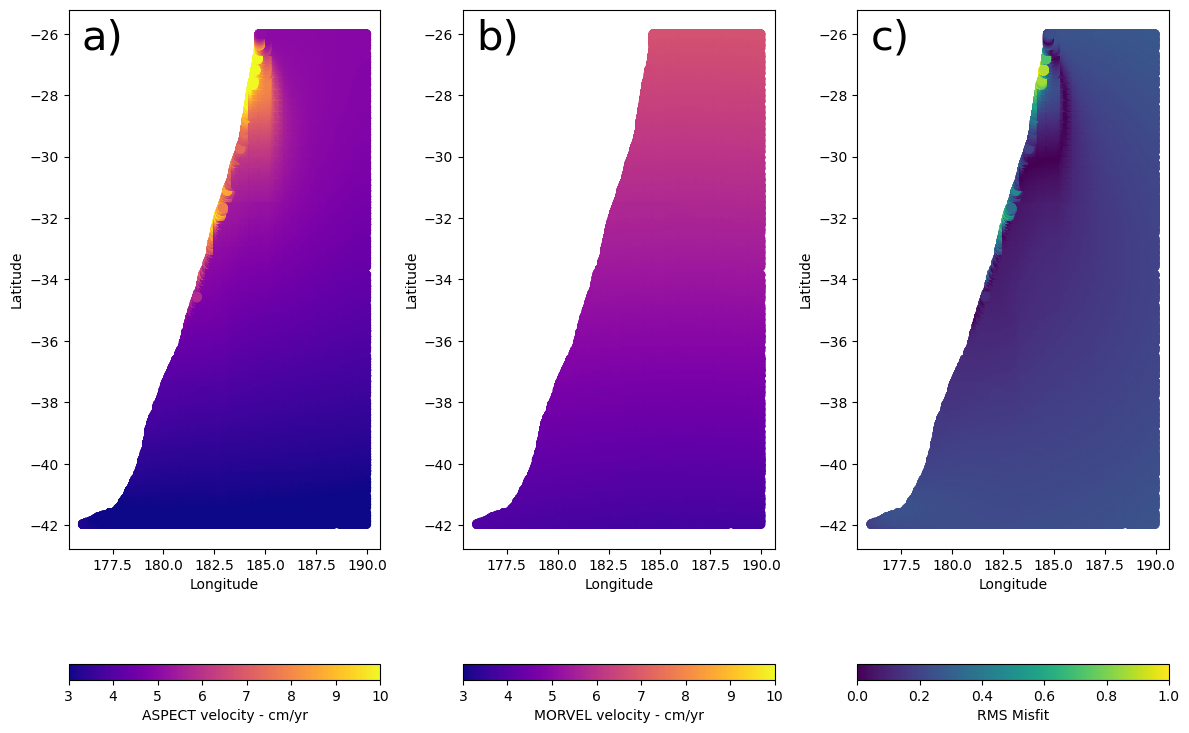

In [4]:
euler_pole_lat = -60.1
euler_pole_lon = -173.7
euler_rotation = 1.079e-6

litho_points = pos_solution[np.where( (crust_total >= 0.5) | (litho_total >= 0.5) )]
litho_R, litho_phi, litho_theta = cartesian_to_spherical(litho_points[:, 0], litho_points[:, 1], litho_points[:, 2])

surface_litho_index_w_trench = np.where( (litho_R >= 6361e3) & \
                                         (litho_theta <= -26) & \
                                         (litho_theta >= - 42) & \
                                         (litho_phi <= 190) )

surface_litho_R_w_trench = litho_R[surface_litho_index_w_trench]
surface_litho_phi_w_trench = litho_phi[surface_litho_index_w_trench]
surface_litho_theta_w_trench = litho_theta[surface_litho_index_w_trench]

surface_litho_phi = np.empty(0)
surface_litho_theta = np.empty(0)
trench_lon_buffer = 0.1

for i in range(len(surface_litho_theta_w_trench)):
    trench_lat_ind = np.abs(trench[:, 1] - surface_litho_theta_w_trench[i]).argmin()
    if surface_litho_phi_w_trench[i] > (trench[trench_lat_ind][0] + trench_lon_buffer):
        surface_litho_phi = np.append(surface_litho_phi, surface_litho_phi_w_trench[i])
        surface_litho_theta = np.append(surface_litho_theta, surface_litho_theta_w_trench[i])

depth = 0
padding = 500
theta, phi, ASPECT_v = MORVEL.ASPECT_surface_velocity(pos_solution[:, 0], pos_solution[:, 1], pos_solution[:, 2], \
                                                      velocity_total, surface_litho_theta, surface_litho_phi, \
                                                      depth, padding)

ASPECT_spherical_v = MORVEL.velocity_converter(theta, phi, ASPECT_v)

v_mag = np.zeros(len(ASPECT_spherical_v))
ASPECT_azimuths = np.zeros(len(ASPECT_spherical_v))
for i in range(len(ASPECT_spherical_v)):
    v_mag[i] = np.sqrt(ASPECT_spherical_v[i][0]**2 + ASPECT_spherical_v[i][1]**2 + ASPECT_spherical_v[i][2]**2) * 100
    ASPECT_azimuths[i] = np.rad2deg(np.arctan(ASPECT_spherical_v[i][2]/ASPECT_spherical_v[i][1]))
ASPECT_azimuths[np.where(ASPECT_azimuths <= 0)] += 180

MORVEL_calc_v, MORVEL_calc_azi = MORVEL.MORVEL_surface_velocity(euler_pole_lat, euler_pole_lon, euler_rotation, \
                                                                surface_litho_theta, surface_litho_phi)
MORVEL_calc_v *= 100
velocity_error = np.sqrt((v_mag - MORVEL_calc_v)**2 / (MORVEL_calc_v)**2)

plt.figure(dpi=100, figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.scatter(surface_litho_phi, surface_litho_theta, c=v_mag, vmin=3, vmax=10, cmap='plasma')
plt.colorbar(orientation='horizontal', label='ASPECT velocity - cm/yr')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.text(176, -26.5, "a)", fontsize=30)

plt.subplot(1, 3, 2)
plt.scatter(surface_litho_phi, surface_litho_theta, c=MORVEL_calc_v, vmin=3, vmax=10, cmap='plasma')
plt.colorbar(orientation='horizontal', label='MORVEL velocity - cm/yr')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.text(176, -26.5, "b)", fontsize=30)

plt.subplot(1, 3, 3)
plt.scatter(surface_litho_phi, surface_litho_theta, c=velocity_error, vmin=0, vmax=1, cmap='viridis')
plt.colorbar(orientation='horizontal', label='RMS Misfit')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.text(176, -26.5, "c)", fontsize=30)

plt.tight_layout()
plt.savefig('RMS_velocity_calculation.png', bbox_inches='tight')
plt.show()